In [1]:
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from heterogp.latent import Latent
from gpflow import settings
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import tensorflow as tf



/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


# Some helper functions

In [2]:
from gpflow.actions import Loop, Action
from gpflow.training import AdamOptimizer

class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
#         logging.warning(self.model)
        
def run_with_adam(model, lr,iterations, callback=None):
    
    adam = AdamOptimizer(lr).make_optimize_action(model)
    
    actions = [adam]#natgrad,
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

# Define some data with input-dependent noise

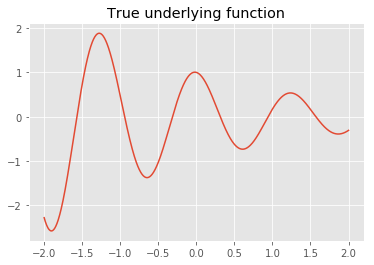

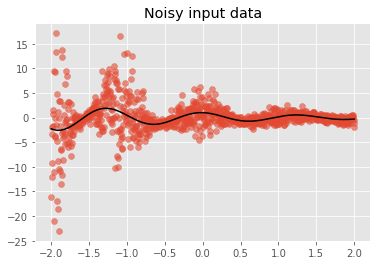

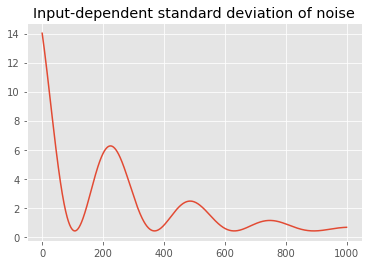

In [3]:
def func(X):
    return np.cos(5*X)*np.exp(-X/2)

N = 1000
X = np.linspace(-2,2,N)[:,None]
noise = 4*np.abs(0.25*(np.cos(6*X)+1)*np.exp(-X) + 0.1)
Y = func(X) + noise*np.random.normal(size=X.shape)

plt.plot(X[:,0],func(X)[:,0],alpha=1.)
plt.title("True underlying function")
plt.show()

plt.scatter(X[:,0],Y[:,0],alpha=0.6)
plt.plot(X[:,0],func(X)[:,0],alpha=1.,c='black')
plt.title("Noisy input data")
plt.show()
plt.title("Input-dependent standard deviation of noise")
plt.plot(noise)
plt.show()

# Vanilla solution

In [4]:
from gpflow.models import SVGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        # Define the likelihood
        likelihood = gp.likelihoods.Gaussian()
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = SVGP(X, Y, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=100,
                     num_latent = 1, 
                     num_data=None,
                     whiten=False,
                    Z=Z)
        model.compile()
    
    run_with_adam(model,1e-3,iterations, PrintAction(model,"Adam"))
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X)
    

2018-05-25 14:12:26,658 Adam: iteration 0 likelihood -44187877.3857
2018-05-25 14:12:26,857 Adam: iteration 1 likelihood -44019288.4166
2018-05-25 14:12:26,924 Adam: iteration 2 likelihood -43856050.0845
2018-05-25 14:12:26,961 Adam: iteration 3 likelihood -43686130.5743
2018-05-25 14:12:27,073 Adam: iteration 4 likelihood -43524227.4882
2018-05-25 14:12:27,108 Adam: iteration 5 likelihood -43365373.0378
2018-05-25 14:12:27,124 Adam: iteration 6 likelihood -43204977.6242
2018-05-25 14:12:27,136 Adam: iteration 7 likelihood -43050957.4431
2018-05-25 14:12:27,210 Adam: iteration 8 likelihood -42896273.8972
2018-05-25 14:12:27,480 Adam: iteration 9 likelihood -42737222.2108
2018-05-25 14:12:27,601 Adam: iteration 10 likelihood -42587615.2097
2018-05-25 14:12:27,685 Adam: iteration 11 likelihood -42436447.1213
2018-05-25 14:12:27,754 Adam: iteration 12 likelihood -42282316.8777
2018-05-25 14:12:27,784 Adam: iteration 13 likelihood -42130784.3092
2018-05-25 14:12:27,837 Adam: iteration 14 l

2018-05-25 14:12:30,451 Adam: iteration 119 likelihood -29712520.7643
2018-05-25 14:12:30,506 Adam: iteration 120 likelihood -29620643.3120
2018-05-25 14:12:30,567 Adam: iteration 121 likelihood -29525990.2070
2018-05-25 14:12:30,593 Adam: iteration 122 likelihood -29431623.1376
2018-05-25 14:12:30,609 Adam: iteration 123 likelihood -29338355.1814
2018-05-25 14:12:30,668 Adam: iteration 124 likelihood -29244365.7029
2018-05-25 14:12:30,721 Adam: iteration 125 likelihood -29152471.0524
2018-05-25 14:12:30,777 Adam: iteration 126 likelihood -29058392.0924
2018-05-25 14:12:30,807 Adam: iteration 127 likelihood -28969622.4816
2018-05-25 14:12:30,820 Adam: iteration 128 likelihood -28873885.9036
2018-05-25 14:12:30,838 Adam: iteration 129 likelihood -28782756.6097
2018-05-25 14:12:30,886 Adam: iteration 130 likelihood -28694467.2578
2018-05-25 14:12:30,904 Adam: iteration 131 likelihood -28602127.8328
2018-05-25 14:12:30,965 Adam: iteration 132 likelihood -28511667.1284
2018-05-25 14:12:31,

2018-05-25 14:12:34,599 Adam: iteration 237 likelihood -20552574.8234
2018-05-25 14:12:34,630 Adam: iteration 238 likelihood -20488496.1094
2018-05-25 14:12:34,706 Adam: iteration 239 likelihood -20422940.2807
2018-05-25 14:12:34,735 Adam: iteration 240 likelihood -20366243.1906
2018-05-25 14:12:34,773 Adam: iteration 241 likelihood -20301482.8600
2018-05-25 14:12:34,810 Adam: iteration 242 likelihood -20238846.9848
2018-05-25 14:12:34,845 Adam: iteration 243 likelihood -20173898.3291
2018-05-25 14:12:34,884 Adam: iteration 244 likelihood -20109943.8377
2018-05-25 14:12:34,916 Adam: iteration 245 likelihood -20053314.7989
2018-05-25 14:12:34,954 Adam: iteration 246 likelihood -19986819.5413
2018-05-25 14:12:34,986 Adam: iteration 247 likelihood -19927537.0009
2018-05-25 14:12:35,046 Adam: iteration 248 likelihood -19863256.9659
2018-05-25 14:12:35,076 Adam: iteration 249 likelihood -19802743.7801
2018-05-25 14:12:35,111 Adam: iteration 250 likelihood -19744219.9906
2018-05-25 14:12:35,

2018-05-25 14:12:37,901 Adam: iteration 355 likelihood -14277621.4266
2018-05-25 14:12:37,915 Adam: iteration 356 likelihood -14237878.2698
2018-05-25 14:12:37,952 Adam: iteration 357 likelihood -14189699.1324
2018-05-25 14:12:37,965 Adam: iteration 358 likelihood -14146633.7757
2018-05-25 14:12:37,997 Adam: iteration 359 likelihood -14102401.5162
2018-05-25 14:12:38,037 Adam: iteration 360 likelihood -14057318.1434
2018-05-25 14:12:38,268 Adam: iteration 361 likelihood -14015927.8838
2018-05-25 14:12:38,326 Adam: iteration 362 likelihood -13972911.5274
2018-05-25 14:12:38,395 Adam: iteration 363 likelihood -13930034.8580
2018-05-25 14:12:38,419 Adam: iteration 364 likelihood -13884280.8727
2018-05-25 14:12:38,445 Adam: iteration 365 likelihood -13844774.0132
2018-05-25 14:12:38,459 Adam: iteration 366 likelihood -13805381.7289
2018-05-25 14:12:38,477 Adam: iteration 367 likelihood -13757366.0960
2018-05-25 14:12:38,493 Adam: iteration 368 likelihood -13718161.5537
2018-05-25 14:12:38,

2018-05-25 14:12:41,326 Adam: iteration 473 likelihood -9901751.5320
2018-05-25 14:12:41,344 Adam: iteration 474 likelihood -9872052.5154
2018-05-25 14:12:41,372 Adam: iteration 475 likelihood -9842684.0934
2018-05-25 14:12:41,398 Adam: iteration 476 likelihood -9815718.9869
2018-05-25 14:12:41,456 Adam: iteration 477 likelihood -9783579.3173
2018-05-25 14:12:41,486 Adam: iteration 478 likelihood -9754781.7414
2018-05-25 14:12:41,518 Adam: iteration 479 likelihood -9718525.9297
2018-05-25 14:12:41,535 Adam: iteration 480 likelihood -9690565.3910
2018-05-25 14:12:41,557 Adam: iteration 481 likelihood -9659418.3835
2018-05-25 14:12:41,586 Adam: iteration 482 likelihood -9634304.9256
2018-05-25 14:12:41,627 Adam: iteration 483 likelihood -9601735.4099
2018-05-25 14:12:41,659 Adam: iteration 484 likelihood -9569529.6665
2018-05-25 14:12:41,703 Adam: iteration 485 likelihood -9542915.0408
2018-05-25 14:12:41,732 Adam: iteration 486 likelihood -9511569.7833
2018-05-25 14:12:41,770 Adam: iter

2018-05-25 14:12:45,278 Adam: iteration 592 likelihood -6837855.4033
2018-05-25 14:12:45,320 Adam: iteration 593 likelihood -6814946.5024
2018-05-25 14:12:45,338 Adam: iteration 594 likelihood -6792007.8754
2018-05-25 14:12:45,382 Adam: iteration 595 likelihood -6771421.0257
2018-05-25 14:12:45,399 Adam: iteration 596 likelihood -6754140.9283
2018-05-25 14:12:45,442 Adam: iteration 597 likelihood -6729829.0519
2018-05-25 14:12:45,475 Adam: iteration 598 likelihood -6709415.8306
2018-05-25 14:12:45,510 Adam: iteration 599 likelihood -6689826.4475
2018-05-25 14:12:45,550 Adam: iteration 600 likelihood -6665147.1907
2018-05-25 14:12:45,577 Adam: iteration 601 likelihood -6650367.8930
2018-05-25 14:12:45,616 Adam: iteration 602 likelihood -6628114.0182
2018-05-25 14:12:45,632 Adam: iteration 603 likelihood -6603027.8544
2018-05-25 14:12:45,661 Adam: iteration 604 likelihood -6585710.4962
2018-05-25 14:12:45,702 Adam: iteration 605 likelihood -6564204.2837
2018-05-25 14:12:45,738 Adam: iter

2018-05-25 14:12:49,468 Adam: iteration 711 likelihood -4719046.6361
2018-05-25 14:12:49,484 Adam: iteration 712 likelihood -4705453.0718
2018-05-25 14:12:49,510 Adam: iteration 713 likelihood -4688861.5379
2018-05-25 14:12:49,549 Adam: iteration 714 likelihood -4673325.4449
2018-05-25 14:12:49,589 Adam: iteration 715 likelihood -4662737.9559
2018-05-25 14:12:49,632 Adam: iteration 716 likelihood -4646625.9902
2018-05-25 14:12:49,670 Adam: iteration 717 likelihood -4632543.8198
2018-05-25 14:12:49,716 Adam: iteration 718 likelihood -4616270.5411
2018-05-25 14:12:49,751 Adam: iteration 719 likelihood -4601725.4375
2018-05-25 14:12:49,787 Adam: iteration 720 likelihood -4588561.5206
2018-05-25 14:12:49,823 Adam: iteration 721 likelihood -4572389.4292
2018-05-25 14:12:49,886 Adam: iteration 722 likelihood -4561351.3550
2018-05-25 14:12:49,917 Adam: iteration 723 likelihood -4546138.1676
2018-05-25 14:12:49,957 Adam: iteration 724 likelihood -4530321.3311
2018-05-25 14:12:50,000 Adam: iter

2018-05-25 14:12:53,154 Adam: iteration 830 likelihood -3267899.4245
2018-05-25 14:12:53,172 Adam: iteration 831 likelihood -3255030.1834
2018-05-25 14:12:53,223 Adam: iteration 832 likelihood -3245232.6210
2018-05-25 14:12:53,240 Adam: iteration 833 likelihood -3236098.4142
2018-05-25 14:12:53,261 Adam: iteration 834 likelihood -3223977.0650
2018-05-25 14:12:53,334 Adam: iteration 835 likelihood -3214944.2894
2018-05-25 14:12:53,541 Adam: iteration 836 likelihood -3205230.7778
2018-05-25 14:12:53,621 Adam: iteration 837 likelihood -3197300.4304
2018-05-25 14:12:53,635 Adam: iteration 838 likelihood -3187016.7420
2018-05-25 14:12:53,646 Adam: iteration 839 likelihood -3174439.4023
2018-05-25 14:12:53,732 Adam: iteration 840 likelihood -3165465.1477
2018-05-25 14:12:53,745 Adam: iteration 841 likelihood -3156596.6871
2018-05-25 14:12:53,763 Adam: iteration 842 likelihood -3148661.6424
2018-05-25 14:12:53,793 Adam: iteration 843 likelihood -3135206.1933
2018-05-25 14:12:53,811 Adam: iter

2018-05-25 14:12:57,006 Adam: iteration 949 likelihood -2270082.4481
2018-05-25 14:12:57,034 Adam: iteration 950 likelihood -2264172.3239
2018-05-25 14:12:57,054 Adam: iteration 951 likelihood -2262023.0041
2018-05-25 14:12:57,074 Adam: iteration 952 likelihood -2250804.0107
2018-05-25 14:12:57,094 Adam: iteration 953 likelihood -2243083.9186
2018-05-25 14:12:57,181 Adam: iteration 954 likelihood -2237294.3183
2018-05-25 14:12:57,204 Adam: iteration 955 likelihood -2229641.1681
2018-05-25 14:12:57,225 Adam: iteration 956 likelihood -2225617.9798
2018-05-25 14:12:57,245 Adam: iteration 957 likelihood -2220285.3755
2018-05-25 14:12:57,309 Adam: iteration 958 likelihood -2210270.3884
2018-05-25 14:12:57,325 Adam: iteration 959 likelihood -2204043.6739
2018-05-25 14:12:57,354 Adam: iteration 960 likelihood -2198483.4859
2018-05-25 14:12:57,366 Adam: iteration 961 likelihood -2192218.7940
2018-05-25 14:12:57,404 Adam: iteration 962 likelihood -2183296.7741
2018-05-25 14:12:57,428 Adam: iter

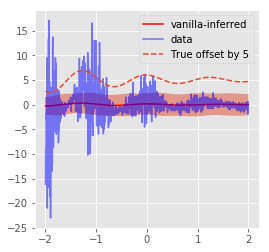

In [5]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar,alpha=1,c='r',label='vanilla-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar+np.sqrt(varstar)),
                 np.squeeze(ystar-np.sqrt(varstar)),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("vanilla.png")
plt.show()

# Define the HGP model and train

We will:
  - Define the latent GP that models the noise
  - Define heteroscedastic likelihood which uses the above latent
  - Define the HGP which has another independent latent modelling the
  underlying function
  - Finally, train with Adam and plot the results

In [6]:
from heterogp.likelihoods import HeteroscedasticGaussian
from heterogp.hgp import HGP

settings.numerics.jitter_level=1e-6
iterations = 1000
Z = np.linspace(-2,2,100)[:,None]

with tf.Session(graph=tf.Graph()) as sess:
    with gp.defer_build():
        
        
        # Define the (log) noise latent
        mean = gp.mean_functions.Constant(np.log(0.5))
        kern = gp.kernels.RBF(1)
        log_noise_latent = Latent(Z, mean, kern, num_latent=1, whiten=False, name=None)
        # Define the likelihood
        likelihood = HeteroscedasticGaussian(log_noise_latent)
        log_noise_latent
        # Define the underlying GP mean and kernel
        mean = gp.mean_functions.Zero()
        kernel = gp.kernels.RBF(1)
        # Create the HGP (note the slightly different order from SVGP)
        model = HGP(X, Y, Z, kernel, likelihood, 
                     mean_function=mean, 
                     minibatch_size=500,
                     num_latent = 1, 
                     num_samples=1,
                     num_data=None,
                     whiten=False)
        model.compile()
    from timeit import default_timer
    t0 = default_timer()
    run_with_adam(model,1e-3,iterations,PrintAction(model,"Adam"))
    print(default_timer() - t0)
    # Predictions uses stochastic sampling and produces 
    # [num_samples,N,D] shape output
    ystar,varstar = model.predict_y(X, 100)
    # For plotting the noise
    hetero_noise = model.likelihood.compute_hetero_noise(X,100)

2018-05-25 14:13:03,361 Adam: iteration 0 likelihood -31271.2286
2018-05-25 14:13:03,781 Adam: iteration 1 likelihood -24413.7523
2018-05-25 14:13:04,081 Adam: iteration 2 likelihood -13502.1343
2018-05-25 14:13:04,530 Adam: iteration 3 likelihood -30381.0442
2018-05-25 14:13:04,798 Adam: iteration 4 likelihood -11512.0320
2018-05-25 14:13:05,029 Adam: iteration 5 likelihood -12883.3332
2018-05-25 14:13:05,220 Adam: iteration 6 likelihood -18020.6048
2018-05-25 14:13:05,399 Adam: iteration 7 likelihood -28549.1794
2018-05-25 14:13:05,600 Adam: iteration 8 likelihood -33989.7650
2018-05-25 14:13:05,789 Adam: iteration 9 likelihood -25782.7853
2018-05-25 14:13:05,956 Adam: iteration 10 likelihood -28830.8314
2018-05-25 14:13:06,108 Adam: iteration 11 likelihood -11777.0623
2018-05-25 14:13:06,568 Adam: iteration 12 likelihood -29391.5552
2018-05-25 14:13:06,759 Adam: iteration 13 likelihood -23374.4881
2018-05-25 14:13:06,941 Adam: iteration 14 likelihood -13363.0729
2018-05-25 14:13:07,

2018-05-25 14:13:33,842 Adam: iteration 125 likelihood -7393.5590
2018-05-25 14:13:34,039 Adam: iteration 126 likelihood -13179.2907
2018-05-25 14:13:34,353 Adam: iteration 127 likelihood -13806.1415
2018-05-25 14:13:34,605 Adam: iteration 128 likelihood -6972.7263
2018-05-25 14:13:35,156 Adam: iteration 129 likelihood -15646.6567
2018-05-25 14:13:35,347 Adam: iteration 130 likelihood -15983.3679
2018-05-25 14:13:35,512 Adam: iteration 131 likelihood -12660.9390
2018-05-25 14:13:35,671 Adam: iteration 132 likelihood -15606.1266
2018-05-25 14:13:35,848 Adam: iteration 133 likelihood -8424.9586
2018-05-25 14:13:36,047 Adam: iteration 134 likelihood -12801.6503
2018-05-25 14:13:36,221 Adam: iteration 135 likelihood -12996.8990
2018-05-25 14:13:36,675 Adam: iteration 136 likelihood -6324.1826
2018-05-25 14:13:37,111 Adam: iteration 137 likelihood -19146.0531
2018-05-25 14:13:37,334 Adam: iteration 138 likelihood -20198.8250
2018-05-25 14:13:37,533 Adam: iteration 139 likelihood -14471.1888

2018-05-25 14:14:06,591 Adam: iteration 249 likelihood -8308.1773
2018-05-25 14:14:06,903 Adam: iteration 250 likelihood -7595.1199
2018-05-25 14:14:07,056 Adam: iteration 251 likelihood -10488.3805
2018-05-25 14:14:07,229 Adam: iteration 252 likelihood -7421.4062
2018-05-25 14:14:07,819 Adam: iteration 253 likelihood -6526.5654
2018-05-25 14:14:08,395 Adam: iteration 254 likelihood -5261.3676
2018-05-25 14:14:08,731 Adam: iteration 255 likelihood -9142.2184
2018-05-25 14:14:09,278 Adam: iteration 256 likelihood -4117.9890
2018-05-25 14:14:09,854 Adam: iteration 257 likelihood -7504.0479
2018-05-25 14:14:10,162 Adam: iteration 258 likelihood -11386.9499
2018-05-25 14:14:10,496 Adam: iteration 259 likelihood -7601.6005
2018-05-25 14:14:10,933 Adam: iteration 260 likelihood -5046.5385
2018-05-25 14:14:11,300 Adam: iteration 261 likelihood -6795.3011
2018-05-25 14:14:11,882 Adam: iteration 262 likelihood -5509.1872
2018-05-25 14:14:12,104 Adam: iteration 263 likelihood -11477.7770
2018-05

2018-05-25 14:14:35,093 Adam: iteration 373 likelihood -7956.7665
2018-05-25 14:14:35,326 Adam: iteration 374 likelihood -6567.5389
2018-05-25 14:14:35,467 Adam: iteration 375 likelihood -8558.7388
2018-05-25 14:14:35,805 Adam: iteration 376 likelihood -7234.4774
2018-05-25 14:14:35,981 Adam: iteration 377 likelihood -9401.2720
2018-05-25 14:14:36,127 Adam: iteration 378 likelihood -4792.6175
2018-05-25 14:14:36,333 Adam: iteration 379 likelihood -8734.1134
2018-05-25 14:14:36,551 Adam: iteration 380 likelihood -6772.5975
2018-05-25 14:14:36,722 Adam: iteration 381 likelihood -5221.3166
2018-05-25 14:14:36,913 Adam: iteration 382 likelihood -6340.2400
2018-05-25 14:14:37,122 Adam: iteration 383 likelihood -6703.7887
2018-05-25 14:14:37,344 Adam: iteration 384 likelihood -6163.7502
2018-05-25 14:14:37,518 Adam: iteration 385 likelihood -6981.9173
2018-05-25 14:14:37,883 Adam: iteration 386 likelihood -7268.9467
2018-05-25 14:14:38,217 Adam: iteration 387 likelihood -6001.6972
2018-05-25

2018-05-25 14:15:08,108 Adam: iteration 498 likelihood -4316.0776
2018-05-25 14:15:08,511 Adam: iteration 499 likelihood -3557.1529
2018-05-25 14:15:08,723 Adam: iteration 500 likelihood -5855.6148
2018-05-25 14:15:08,927 Adam: iteration 501 likelihood -6127.2400
2018-05-25 14:15:09,237 Adam: iteration 502 likelihood -5138.3287
2018-05-25 14:15:09,454 Adam: iteration 503 likelihood -4546.8594
2018-05-25 14:15:09,651 Adam: iteration 504 likelihood -3931.9175
2018-05-25 14:15:09,983 Adam: iteration 505 likelihood -3995.3063
2018-05-25 14:15:10,222 Adam: iteration 506 likelihood -3991.4224
2018-05-25 14:15:10,632 Adam: iteration 507 likelihood -5952.1196
2018-05-25 14:15:10,874 Adam: iteration 508 likelihood -3602.6722
2018-05-25 14:15:11,107 Adam: iteration 509 likelihood -3899.7276
2018-05-25 14:15:11,457 Adam: iteration 510 likelihood -2705.3871
2018-05-25 14:15:11,659 Adam: iteration 511 likelihood -6078.3367
2018-05-25 14:15:11,965 Adam: iteration 512 likelihood -6198.7961
2018-05-25

2018-05-25 14:15:38,568 Adam: iteration 623 likelihood -2867.8648
2018-05-25 14:15:38,927 Adam: iteration 624 likelihood -2963.0903
2018-05-25 14:15:39,116 Adam: iteration 625 likelihood -2739.9971
2018-05-25 14:15:39,351 Adam: iteration 626 likelihood -2421.3114
2018-05-25 14:15:39,685 Adam: iteration 627 likelihood -3024.6368
2018-05-25 14:15:39,940 Adam: iteration 628 likelihood -2987.9620
2018-05-25 14:15:40,166 Adam: iteration 629 likelihood -2146.3255
2018-05-25 14:15:40,524 Adam: iteration 630 likelihood -2440.4972
2018-05-25 14:15:40,714 Adam: iteration 631 likelihood -1908.5995
2018-05-25 14:15:41,135 Adam: iteration 632 likelihood -3382.0879
2018-05-25 14:15:41,371 Adam: iteration 633 likelihood -3280.4136
2018-05-25 14:15:41,718 Adam: iteration 634 likelihood -2435.6859
2018-05-25 14:15:41,897 Adam: iteration 635 likelihood -2356.4921
2018-05-25 14:15:42,079 Adam: iteration 636 likelihood -2832.7201
2018-05-25 14:15:42,428 Adam: iteration 637 likelihood -2079.5627
2018-05-25

2018-05-25 14:16:09,866 Adam: iteration 748 likelihood -1949.5249
2018-05-25 14:16:10,022 Adam: iteration 749 likelihood -2048.9713
2018-05-25 14:16:10,329 Adam: iteration 750 likelihood -1810.0949
2018-05-25 14:16:10,599 Adam: iteration 751 likelihood -2125.5899
2018-05-25 14:16:10,803 Adam: iteration 752 likelihood -1929.6728
2018-05-25 14:16:10,961 Adam: iteration 753 likelihood -1997.6373
2018-05-25 14:16:11,113 Adam: iteration 754 likelihood -2018.1915
2018-05-25 14:16:11,249 Adam: iteration 755 likelihood -1939.0500
2018-05-25 14:16:11,614 Adam: iteration 756 likelihood -1995.4352
2018-05-25 14:16:11,929 Adam: iteration 757 likelihood -2010.5682
2018-05-25 14:16:12,133 Adam: iteration 758 likelihood -1876.8096
2018-05-25 14:16:12,305 Adam: iteration 759 likelihood -2351.1204
2018-05-25 14:16:12,666 Adam: iteration 760 likelihood -2247.2171
2018-05-25 14:16:12,835 Adam: iteration 761 likelihood -1757.4602
2018-05-25 14:16:13,034 Adam: iteration 762 likelihood -2247.1157
2018-05-25

2018-05-25 14:16:39,090 Adam: iteration 873 likelihood -1982.6196
2018-05-25 14:16:39,262 Adam: iteration 874 likelihood -1862.4792
2018-05-25 14:16:39,453 Adam: iteration 875 likelihood -1952.7544
2018-05-25 14:16:39,676 Adam: iteration 876 likelihood -2028.8507
2018-05-25 14:16:40,197 Adam: iteration 877 likelihood -1766.4830
2018-05-25 14:16:40,409 Adam: iteration 878 likelihood -1882.3323
2018-05-25 14:16:40,588 Adam: iteration 879 likelihood -2007.7908
2018-05-25 14:16:40,757 Adam: iteration 880 likelihood -1830.1779
2018-05-25 14:16:40,943 Adam: iteration 881 likelihood -1746.8239
2018-05-25 14:16:41,147 Adam: iteration 882 likelihood -1993.3371
2018-05-25 14:16:41,302 Adam: iteration 883 likelihood -2076.2042
2018-05-25 14:16:41,470 Adam: iteration 884 likelihood -1847.4105
2018-05-25 14:16:41,639 Adam: iteration 885 likelihood -1698.0786
2018-05-25 14:16:41,772 Adam: iteration 886 likelihood -1862.3268
2018-05-25 14:16:42,112 Adam: iteration 887 likelihood -1994.8538
2018-05-25

2018-05-25 14:17:02,257 Adam: iteration 998 likelihood -1785.8512
2018-05-25 14:17:02,638 Adam: iteration 999 likelihood -1869.3461


243.46059775797767


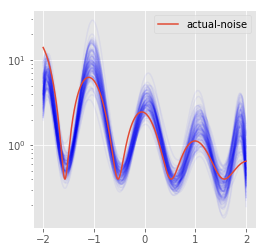

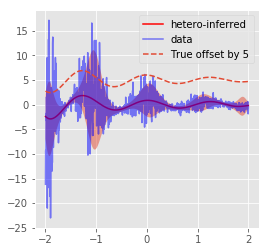

In [7]:
plt.figure(figsize=(4,4))
plt.plot(X[:,0],hetero_noise[:,:,0].T,alpha=0.05,c='b')
# plt.title("Samples for the noise latent")
plt.plot(X[:,0],noise,label='actual-noise')
plt.yscale('log')
plt.legend()
plt.savefig("inferred_noise.png")
plt.show()

plt.figure(figsize=(4,4))
plt.plot(X[:,0],ystar.mean(0),alpha=1,c='r',label='hetero-inferred')
plt.fill_between(X[:,0],np.squeeze(ystar.mean(0)+np.sqrt(varstar.mean(0))),
                 np.squeeze(ystar.mean(0)-np.sqrt(varstar.mean(0))),
                 alpha=0.5)
plt.plot(X[:,0],Y[:,0],c='b',alpha=0.5,label='data')
plt.plot(X[:,0],func(X) + 5,ls='--',label='True offset by 5')
plt.legend()
# plt.title("Inferred solution on data")
plt.savefig("hetero_inferred.png")
plt.show()